# Image Scene Classification of Multiclass labels

The objective of this code is classifying the image using CNN with Keras. The dataset is a collection of images of Natural Scenes around the world.  
This Data contains around 25k images of size 150x150 distributed under 6 categories.  
{'buildings' -> 0,  
'forest' -> 1,  
'glacier' -> 2,  
'mountain' -> 3,  
'sea' -> 4,  
'street' -> 5 }  
The Train, Test and Prediction data is separated in each zip files. There are around 14k images in Train, 3k in Test and 7k in Prediction.  
This data was initially published on https://datahack.analyticsvidhya.com by Intel to host a Image classification Challenge.  
This program is written for a competition of kaggle and can be found at https://www.kaggle.com/puneet6060/intel-image-classification .  

## Setup workspace

In [1]:
#!pip install pip --upgrade --user
#pip install tensorflow --upgrade --user

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#we can limit the number of parallel threads
#tf.config.threading.set_intra_op_parallelism_threads(16)

To train the model, all images will be resized to *[img_height,img_width]*.  
The data consist of *class_num* different label with names *class_names*. *class_num* and *class_names* can be used when we just predict the model. They will be replaced with *image_dataset_from_directory* in the reading training and validation datasets of the code for the training of the model. 

Because We trained our model and saved it, we disable training part of the code using *Please_pretrain* and *Please_train*.
All needed information are saved in the folder *saved_model*.
If you like to train the model just activate *Please_pretrain* and *Please_train*.

In [2]:
batch_size = 32
img_height = 150 
img_width = 150

Please_pretrain=False
Please_train=False


class_num=6
class_names=['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

## Reading training and validation datasets
Train and validation datasets are placed in folders *data_dir_train* and *data_dir_val*.  
Function named *image_dataset_from_directory* reads all subfolders in the selected path and make labels for them. 

In [3]:
data_dir_train = "./seg_train/seg_train"
data_dir_val   = "./seg_test/seg_test"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  subset="training",
  validation_split=0.01,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_val,
  subset="validation",
  validation_split=0.99,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
class_num=len(class_names)
print("%i classes with Class names: " % class_num,class_names)


Found 14034 files belonging to 6 classes.
Using 13894 files for training.
Found 3000 files belonging to 6 classes.
Using 2970 files for validation.
6 classes with Class names:  ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


Some random figures with their labels are shown in the following. 

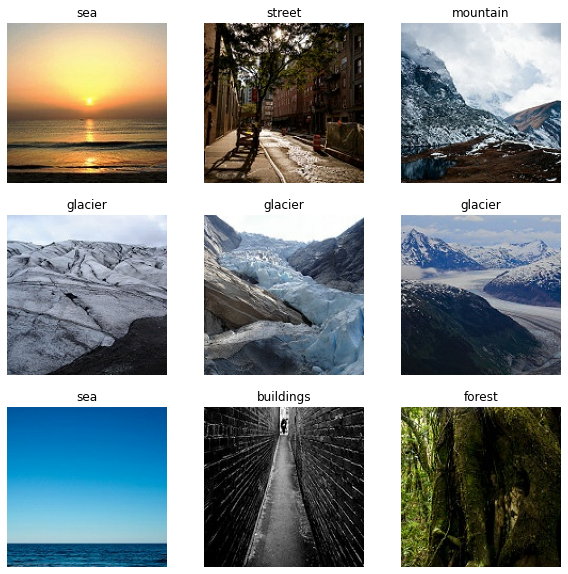

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

To make the data more general, we used random flip and random rotation for preprocessing data. The results is shown in the following. 

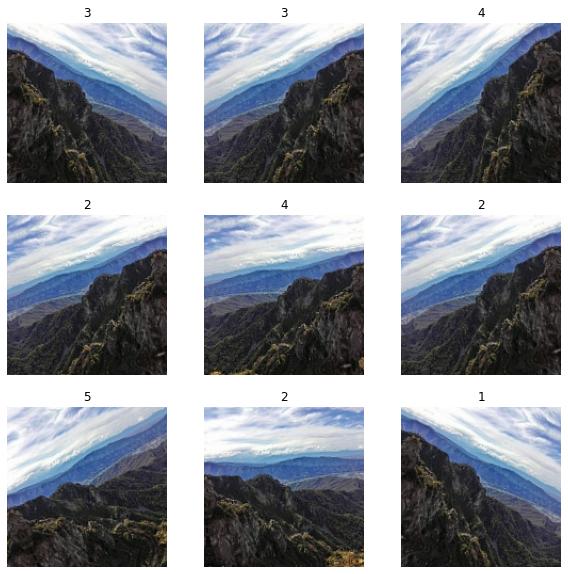

In [6]:
data_augmentation = keras.Sequential(
    [
        #layers.experimental.preprocessing.Rescaling(1./255),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[i]))
        plt.axis("off")

# Make the model using InceptionV3
**Inception v3** is a convolutional neural network for assisting in image analysis and object detection. In this model,
by rethinking the inception architecture, computational efficiency and fewer parameters are realized. With fewer parameters, 42-layer deep learning network, with similar complexity as VGGNet, can be achieved.The roadmap of the model is shown as follows. 
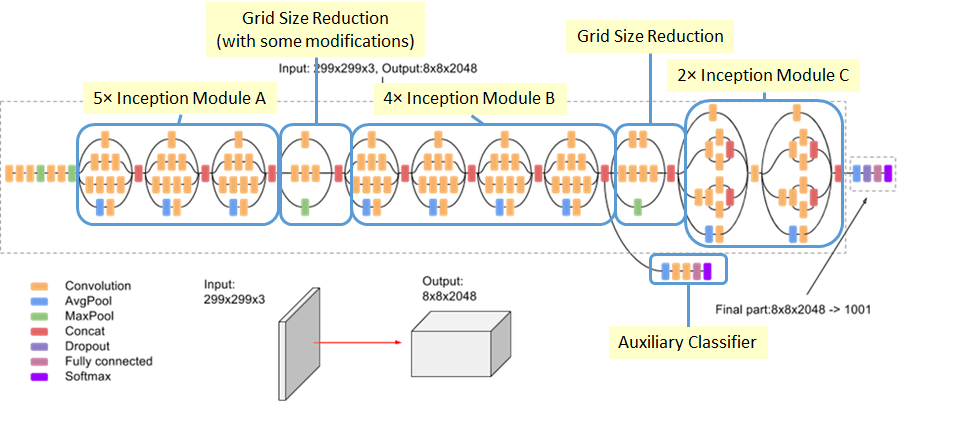

To make the model, we use *InceptionV3* as the base model and *data_augmentation* to scale, rotate, and flip the input data. To train our model, first we should rescale the image data by *Rescaling*. 

In [4]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.Rescaling(1./255),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)
base_model = keras.applications.InceptionV3(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(img_height, img_width, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.



# Create new model on top
inputs = keras.Input(shape=(img_height, img_width , 3))
x = data_augmentation(inputs)  # Apply random data augmentation

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(class_num, activation = tf.nn.softmax)(x)
model = keras.Model(inputs, outputs)


# Compiling and pretrainig the data
To train the model, first, we freeze the base model and fit the data. The fitted model will be save in *saved_model/my_model_pretrained* folder for the later use. 

In [8]:
%%time
if Please_pretrain:
    # first: train only the top layers (which were randomly initialized)
    # i.e. freeze all convolutional InceptionV3 layers
    base_model.trainable = False
    
    model.summary()
    
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss="sparse_categorical_crossentropy",
        metrics=['acc'],
    )
    epochs = 40
    result=model.fit(train_ds, epochs=epochs, validation_data=val_ds)
    
    # Save the entire model as a SavedModel.
    !mkdir -p saved_model
    model.save('saved_model/my_model_pretrained')

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 150, 150, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 6150  

The pretraining and validation accuracy during the fiting is shown as below. 

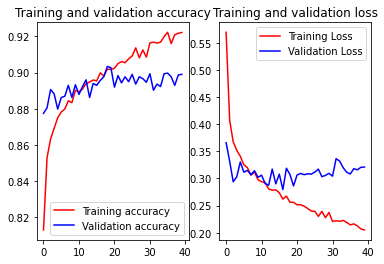

In [9]:
if Please_pretrain:
    acc = result.history['acc']
    val_acc = result.history['val_acc']
    loss = result.history['loss']
    val_loss = result.history['val_loss']

    epochs = range(len(acc))

    ax = plt.subplot(1,2,1)
    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    #plt.figure()

    ax = plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

# Compiling and training the data
Now it's the time to train the full data.  
the trained model will be saved in the *saved_model/my_model_trained* folder for the further use.

In [10]:
%%time
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
# the first 249 layers and unfreeze the rest:
if Please_train:
    # Load the previously saved weights
    if Please_pretrain==False:
        model.load_weights('saved_model/my_model_pretrained')

    # Unfreeze the base_model. Note that it keeps running in inference mode
    # since we passed `training=False` when calling it. This means that
    # the batchnorm layers will not update their batch statistics.
    # This prevents the batchnorm layers from undoing all the training
    # we've done so far.
    #base_model.trainable = True
    for layer in base_model.layers[:249]:
       layer.trainable = False
    for layer in base_model.layers[249:]:
       layer.trainable = True

    model.summary()

    # we need to recompile the model for these modifications to take effect
    # we use SGD with a low learning rate
    model.compile(optimizer=keras.optimizers.Adam(1e-5), loss='sparse_categorical_crossentropy', metrics=['acc'])


    epochs = 30
    result=model.fit(train_ds, epochs=epochs, validation_data=val_ds)
    
    # Save the entire model as a SavedModel.
    !mkdir -p saved_model
    model.save('saved_model/my_model_trained')

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 150, 150, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 6150  

The training accuracy and loss function are showns as below.

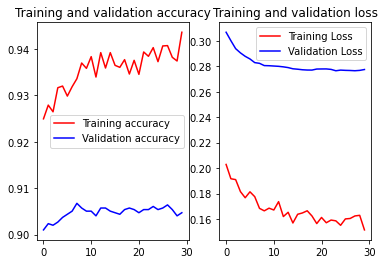

In [11]:
if Please_train:
    acc = result.history['acc']
    val_acc = result.history['val_acc']
    loss = result.history['loss']
    val_loss = result.history['val_loss']

    epochs = range(len(acc))

    ax = plt.subplot(1,2,1)
    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    #plt.figure()

    ax = plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

# Predicting the model from the trained model
Now it's the time to use our model. First, we load the weights. Then we read some images from *data_dir_pred* folder. and finally we predict the image kinds.  

In [5]:
# Load the previously saved weights
model.load_weights('saved_model/my_model_trained')

### Read images to predict

In [7]:
data_dir_pred = './seg_pred/seg_pred'

pred_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_pred,
  label_mode=None,
  #subset="training",
  #validation_split=0.2,
  seed=123,
  shuffle=False,
  image_size=(img_height, img_width),
  batch_size=1)


Found 7301 files belonging to 1 classes.


### predicting the label of all images
Here we choose *num_pred* for the number of images that we would like to predict their label.  
To have more information, we show all labels and the percentage of their prediction. The max percentage of each prediction will be choosen as the label prediction of the coresponding image.  

There can be some errors in the prediction. One of the important error corresponds to the mixture of labels which are exist in each image. Some images are a mix of two or more labels. For example, The fowwloing image shows both street and the building at the same time. Depending how much of both label exist in the image, the code decides to choose the lable.   
<center>{'buildings': '36%', 'street': '64%'}</center>

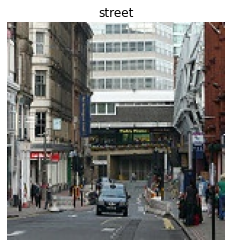  

In the following we take *num_pred* the number of random images in the prediction folder and predict their lablels.

{'buildings': '97%'}


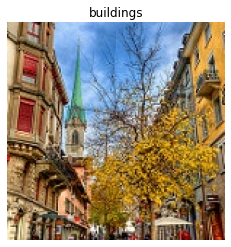

{'glacier': '19%', 'mountain': '80%'}


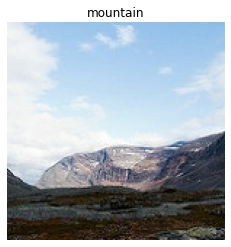

{'buildings': '36%', 'street': '64%'}


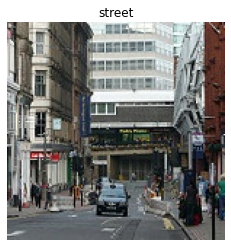

{'glacier': '12%', 'mountain': '88%'}


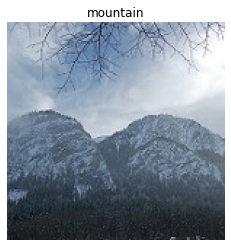

{'glacier': '31%', 'mountain': '69%'}


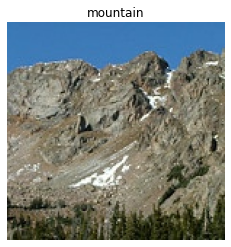

{'forest': '93%'}


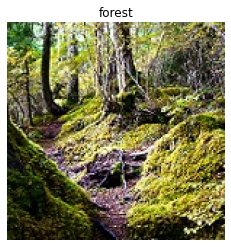

{'sea': '100%'}


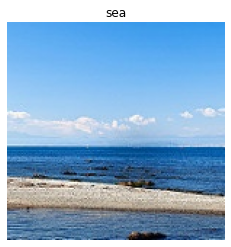

{'glacier': '100%'}


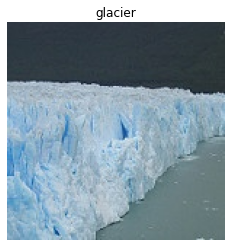

{'sea': '100%'}


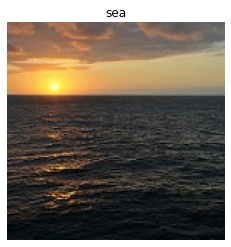

{'street': '96%'}


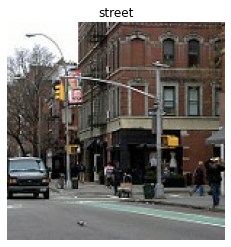

{'sea': '100%'}


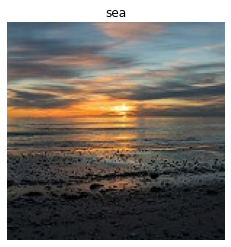

{'street': '100%'}


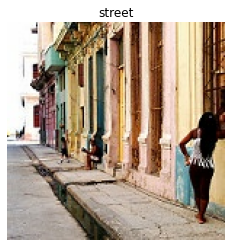

{'mountain': '99%'}


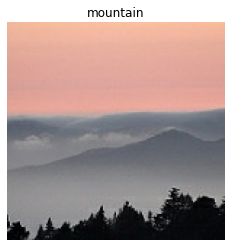

{'buildings': '100%'}


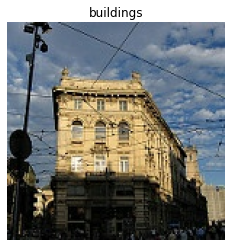

{'buildings': '100%'}


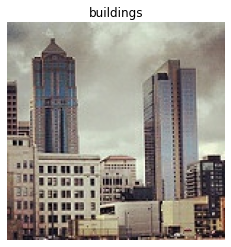

{'glacier': '100%'}


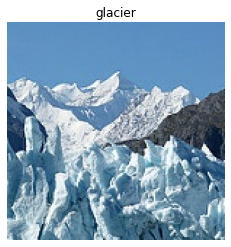

{'forest': '100%'}


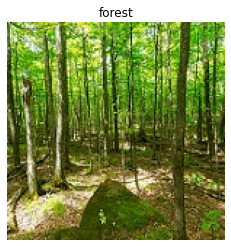

{'forest': '100%'}


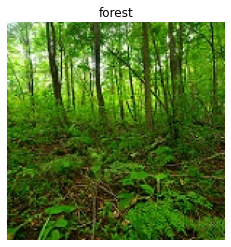

{'glacier': '34%', 'mountain': '66%'}


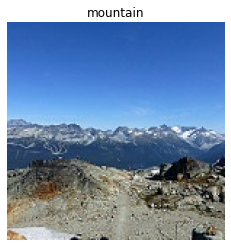

{'sea': '100%'}


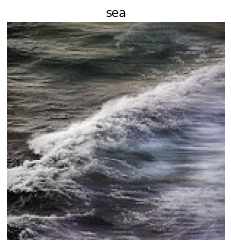

{'buildings': '18%', 'street': '82%'}


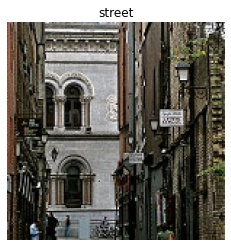

{'buildings': '12%', 'street': '88%'}


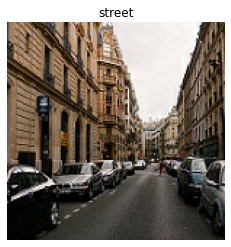

{'street': '100%'}


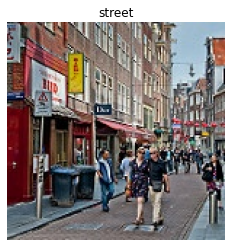

{'street': '99%'}


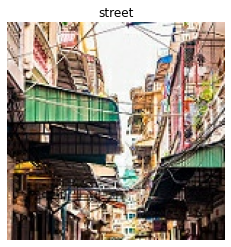

{'glacier': '100%'}


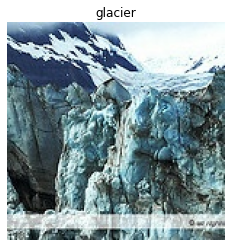

{'buildings': '11%', 'street': '89%'}


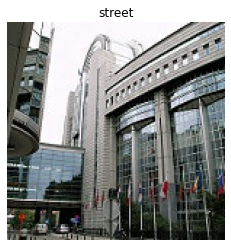

{'forest': '100%'}


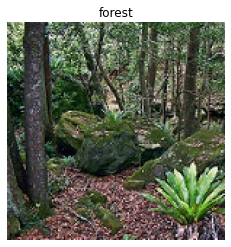

{'mountain': '93%'}


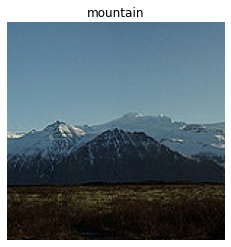

{'glacier': '100%'}


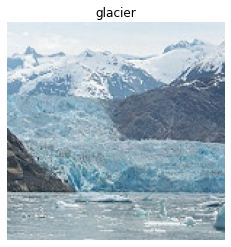

{'mountain': '100%'}


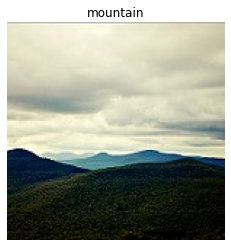

In [34]:
num_pred=30

data_for_predict=pred_ds.take(num_pred)

prediction=(model.predict(data_for_predict)).astype(float)
lable_pred=np.argmax(prediction,axis=1)
percent_pred=np.amax(prediction,axis=1)
class1=np.array(class_names)
lable_pred=class1[lable_pred]
list_prediction=list(map(list, zip(lable_pred,percent_pred)))

def make_dic(class_names,prediction):
    dic={}
    N=len(class_names)
    for i in range(N):
        if abs(prediction[i])>10.E-2:
            dic.update({class_names[i]:"{:.0%}".format( prediction[i])})
    return dic
        

import matplotlib.pyplot as plt
i=0
for images in data_for_predict:
    #ax = plt.subplot(3, 3, i + 1)
    #print(class_names)
    #print(prediction[i])
    print(make_dic(class_names,prediction[i]))
    plt.imshow(images[0].numpy().astype("uint8"))
    plt.title(list_prediction[i][0])
    plt.axis("off")
    #plt.figure()
    plt.show()
    i+=1

# All layer informations for base_model and model

In [15]:

for layer in base_model.layers:
   print(layer.name)
for layer in model.layers:
   print(layer.name)

input_1
conv2d
batch_normalization
activation
conv2d_1
batch_normalization_1
activation_1
conv2d_2
batch_normalization_2
activation_2
max_pooling2d
conv2d_3
batch_normalization_3
activation_3
conv2d_4
batch_normalization_4
activation_4
max_pooling2d_1
conv2d_8
batch_normalization_8
activation_8
conv2d_6
conv2d_9
batch_normalization_6
batch_normalization_9
activation_6
activation_9
average_pooling2d
conv2d_5
conv2d_7
conv2d_10
conv2d_11
batch_normalization_5
batch_normalization_7
batch_normalization_10
batch_normalization_11
activation_5
activation_7
activation_10
activation_11
mixed0
conv2d_15
batch_normalization_15
activation_15
conv2d_13
conv2d_16
batch_normalization_13
batch_normalization_16
activation_13
activation_16
average_pooling2d_1
conv2d_12
conv2d_14
conv2d_17
conv2d_18
batch_normalization_12
batch_normalization_14
batch_normalization_17
batch_normalization_18
activation_12
activation_14
activation_17
activation_18
mixed1
conv2d_22
batch_normalization_22
activation_22
conv2d